In [2]:
import sys
import numpy as np
import numpy.linalg as la 
from sklearn.preprocessing import normalize
from oct2py import octave
from matplotlib import pyplot as plt 
from scipy import signal
from sklearn.decomposition import fastica
from itertools import permutations, product
from scipy import stats
import random
import math
from tqdm import tqdm


def plusAndMinusPermutations(items):
    for p in permutations(items):
        for signs in product([-1,1], repeat=len(items)):
            yield [a*sign for a,sign in zip(p,signs)]

def Frobenius_Norm(A, A_):
    return np.sqrt(np.trace(np.subtract(A, A_)@np.subtract(A,A_).conj().T))

octave.addpath('~/Github/NSF-Phase1/Blaine/fastica');
def radial_fb(X, val, q): # Set q to be the qth quantile
    return 1 / np.quantile((X.T).dot(val), q)

def compute_polar_fb(X, q):
    polar_body = np.ones((2,0))
    for i in range(X.shape[1]):
        if radial_fb(X, X[:,i] / la.norm(X[:,i]), q) >= la.norm(X[:,i]):
            yeet = np.array(X[:,i]).reshape(2,1)
            polar_body = np.hstack((polar_body, yeet))
    return polar_body

def compute_fb(X, q):
    Kpol = compute_polar_fb(X, q)
    floating_body = np.ones((2,0))
    maxVal = 0
    maxPoint = np.ones((2,0))
    for i in range(X.shape[1]):
        dotValMat = (X[:,i].T).dot(Kpol)
        for j in range(dotValMat.shape[0]):
            if dotValMat[j] > maxVal:
                maxVal = dotValMat[j]        
        if maxVal <= 1:
            maxPoint = np.array(X[:,i]).reshape(2,1)
            floating_body = np.hstack((floating_body, maxPoint))
        maxVal = 0
    return floating_body
def Get_Min(A,A_):
    i = np.eye(A.shape[0])
    perm = list(plusAndMinusPermutations(i))
    min = Frobenius_Norm(A, A_)
#     print("A:")
#     print(A)
#     print("")
#     print("A_:")
#     print(A_)
#     print("")
    for j in perm:
        j = np.array(j)
        j[j == -0] = 0
        mat = A@np.array(j)
#         print("Guess:")
#         print(mat)
#         print("")
        temp = Frobenius_Norm(mat, A_)
#         print(temp)
        if(temp < min):
#             print("MIN:")
#             print(mat)
#             print("")
            min = temp
        
    return min

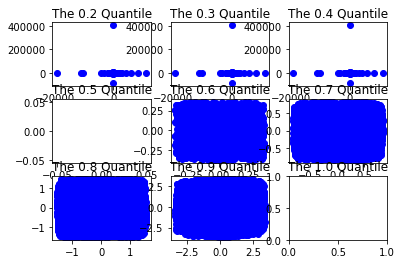

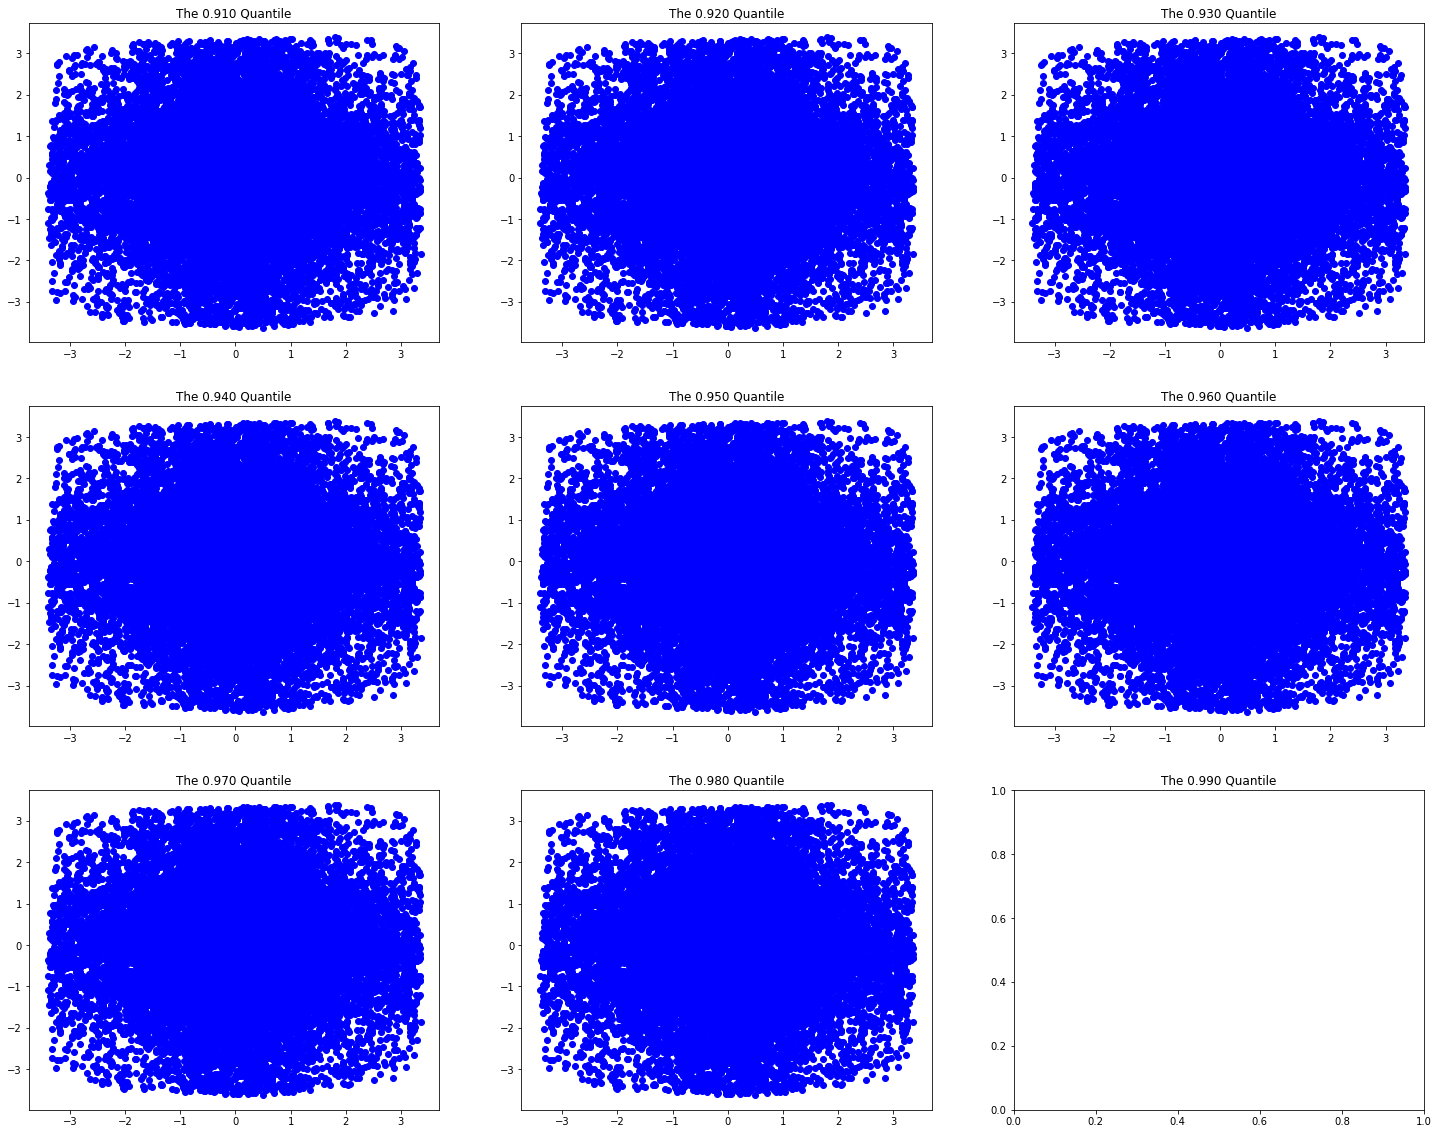

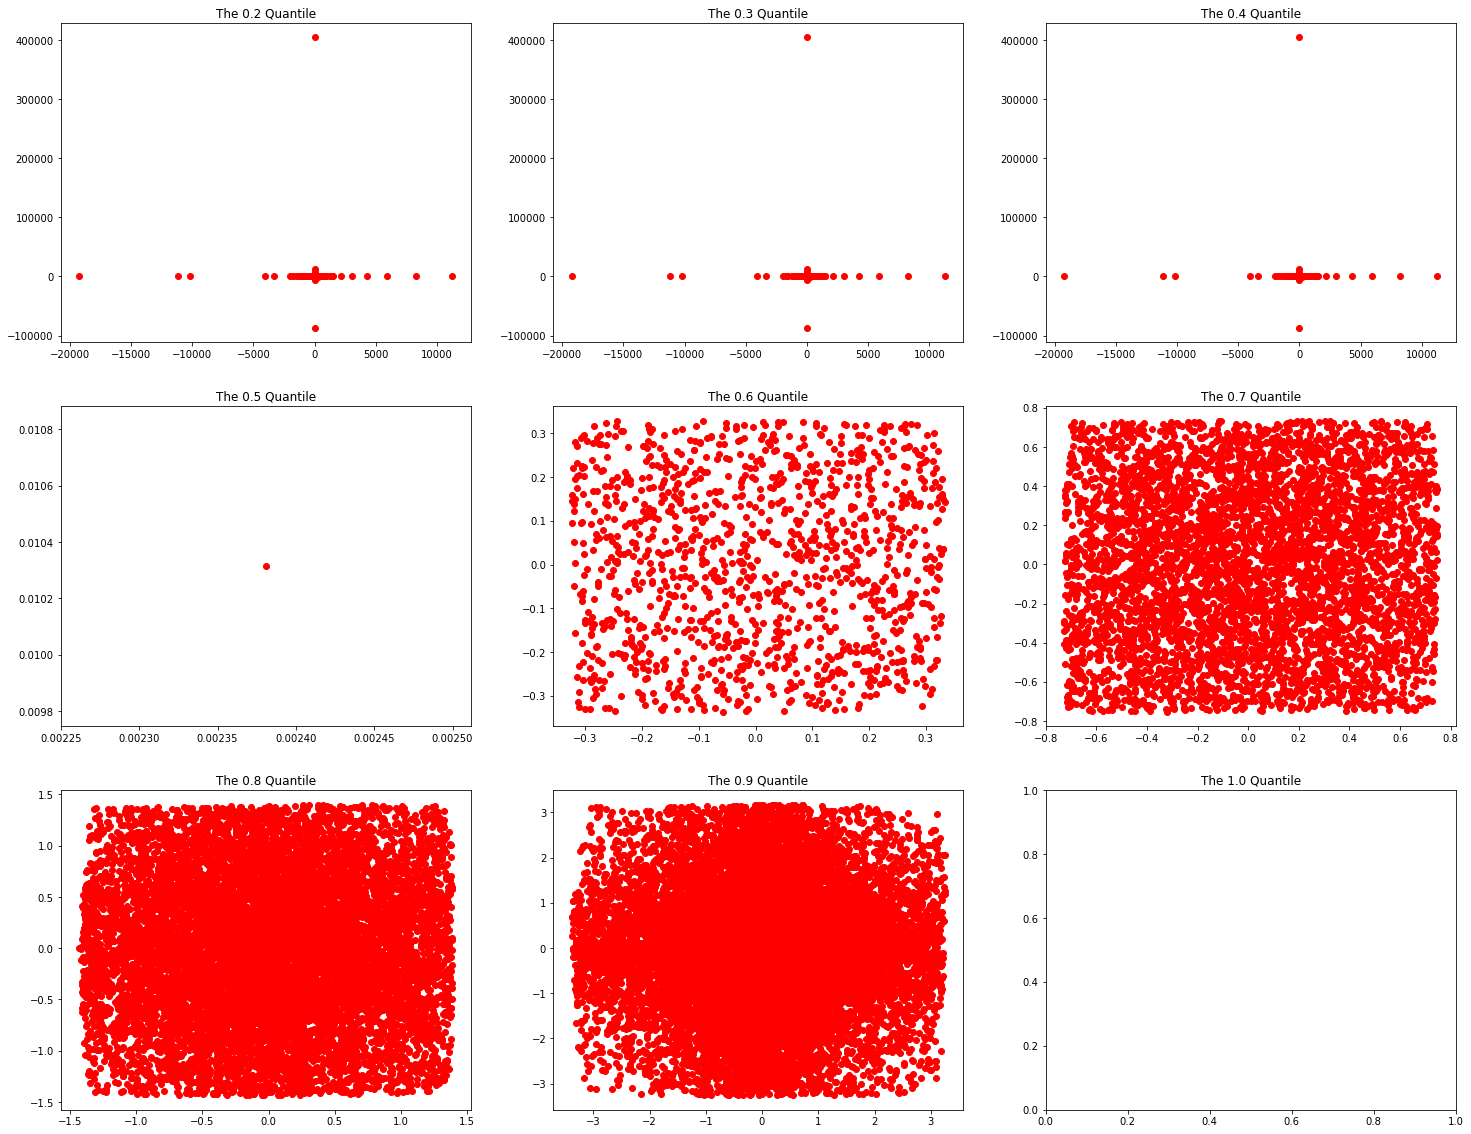

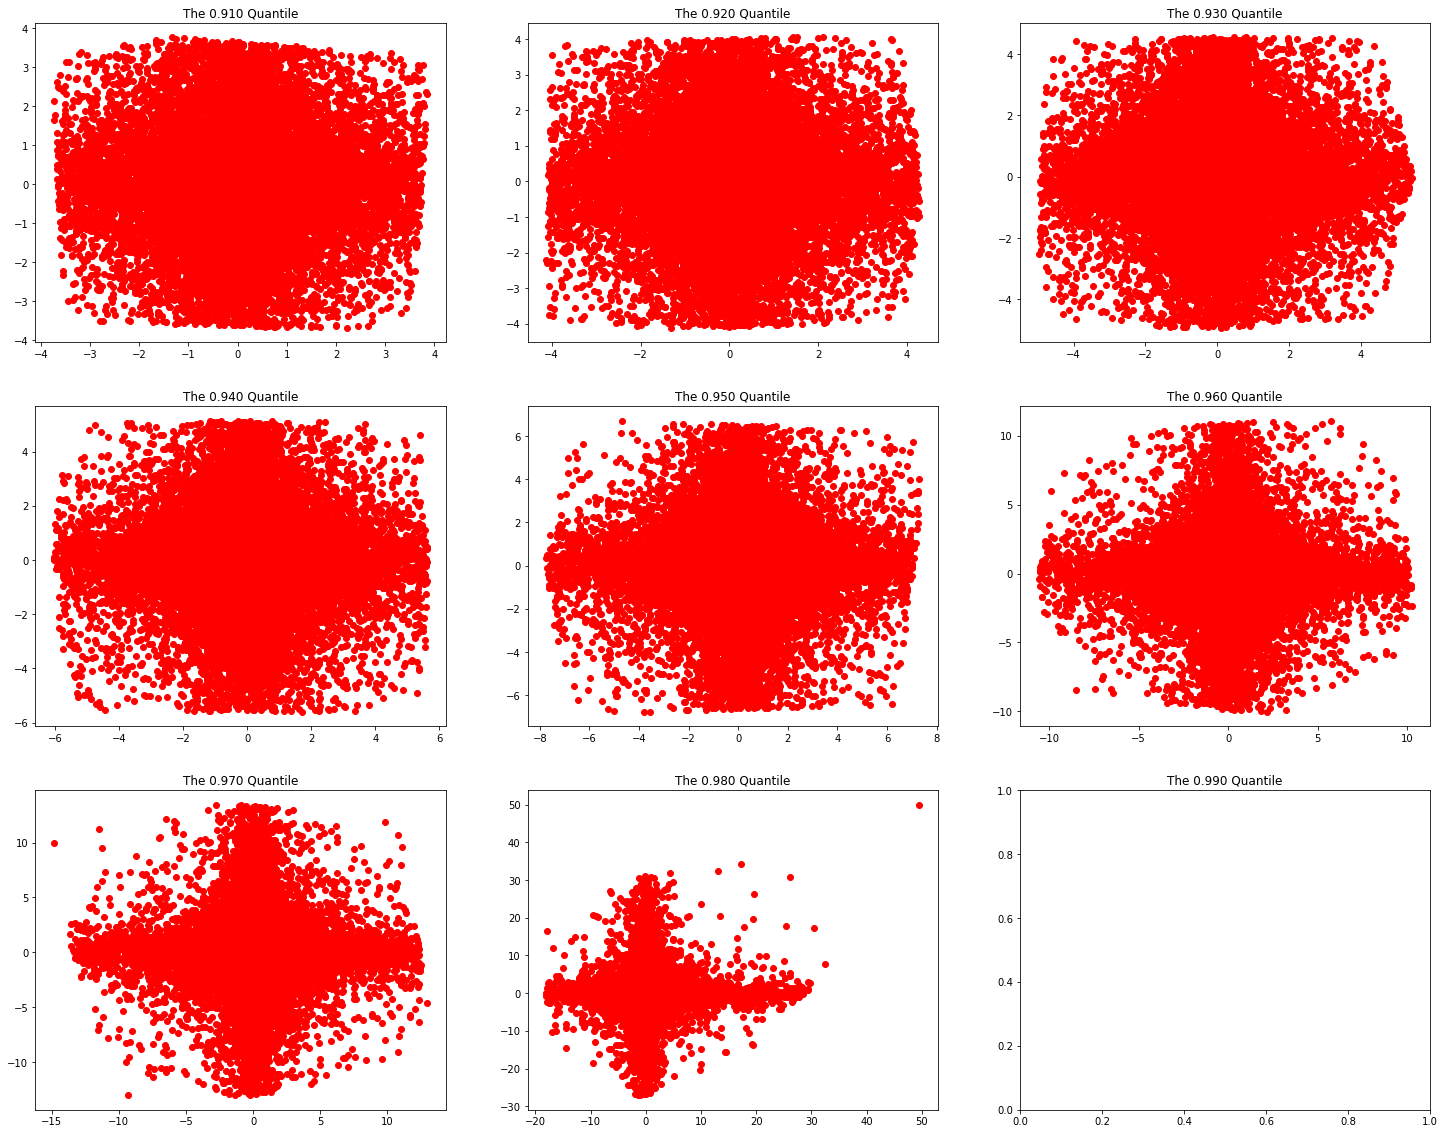

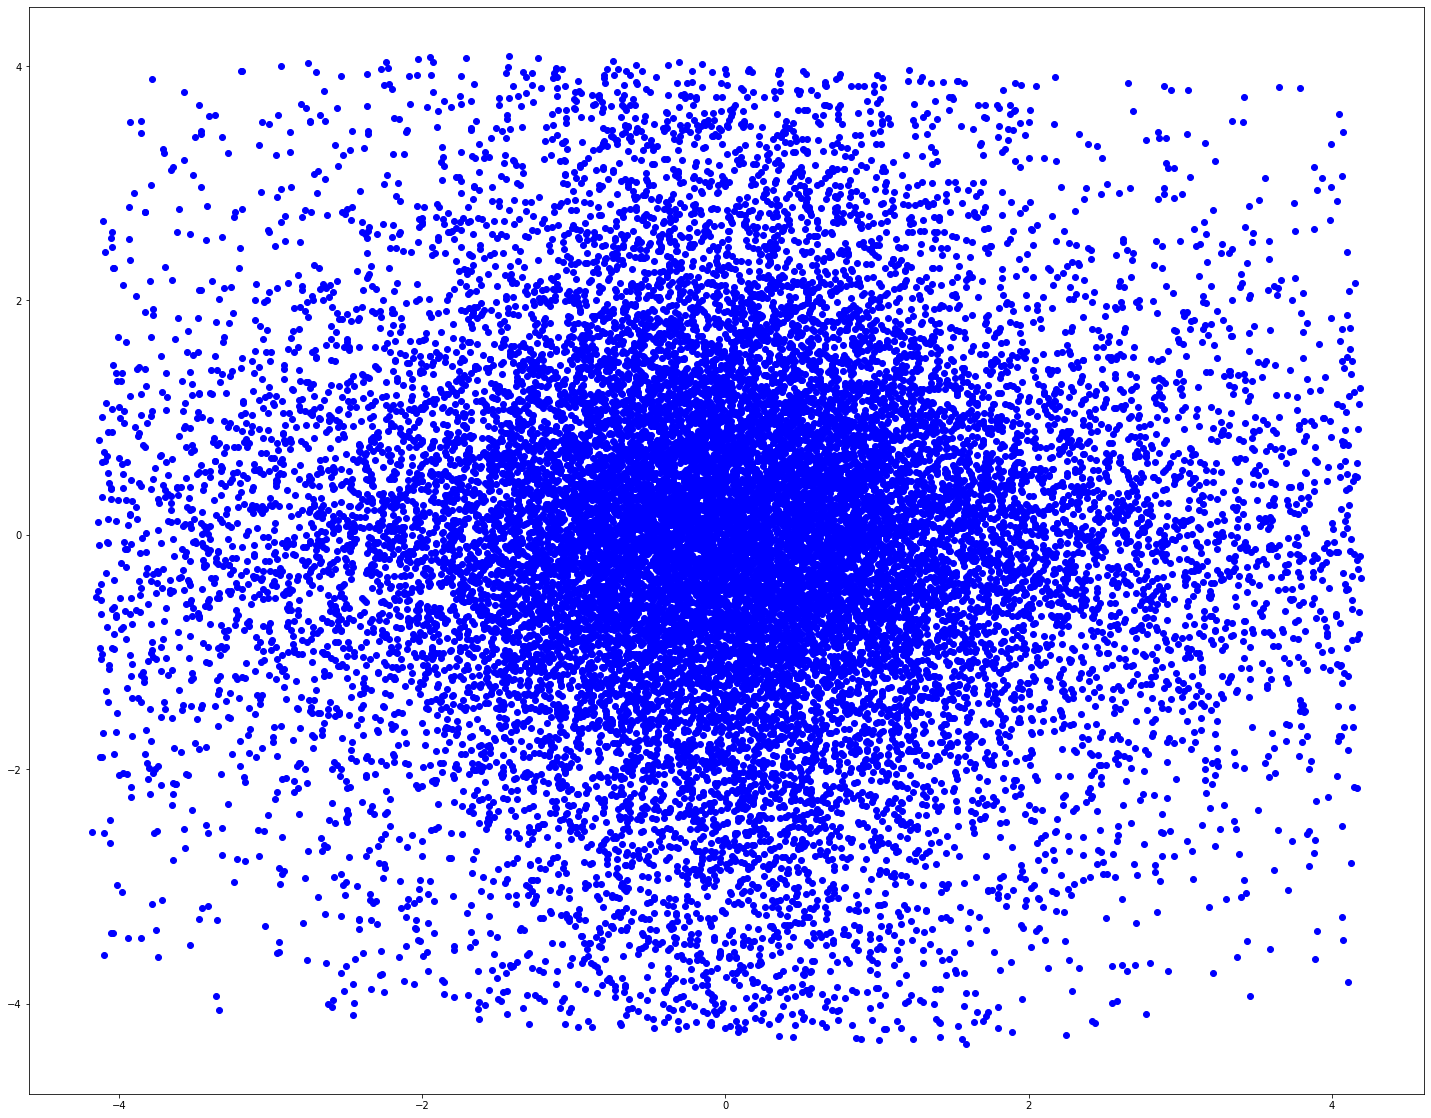

TypeError: 'NoneType' object is not subscriptable

In [5]:

samp = np.arange(10000, 1000000, 10000)
Error = np.array([])
samples = 30000

n = 2
#Generate A Random Matrix Given n and samples
#print("Generated a", n, "x", samples, "matrix of Uniform RND samples...") 
S = np.zeros((n,1))            
#Uniform samples from the n-dimensional simplex 
for i in range(samples):
    U = np.random.uniform(0,1,n)
    tmp = np.array([0,1])
    Final = np.zeros(n)
    U = np.hstack((U,tmp))
    U = np.sort(U)
    for i in range(1,n+1):
        Final[i-1] = U[i] - U[i-1]
    S = np.hstack((S, np.reshape(Final, (n,1))))
S = np.delete(S, 0,1)

#Uniform in the l-1 ball by flipping signs
for i in range(S.shape[1]):
    binom = np.random.binomial(1,.5)
    if(binom == 1):
        S[0][i] = S[0][i]*(-1)
for i in range(S.shape[1]):
    binom = np.random.binomial(1,.5)
    if(binom == 1):
        S[1][i] = S[1][i]*(-1)



Cauchy = np.random.standard_cauchy((n,S.shape[1]))
S = S + Cauchy
num = .1
for i in range(1,10):
    fb = compute_fb(S, num)
    S_ = fb.copy()
    num = num + .1
    plt.plot(S_[0,:], S_[1,:], "bo")
    plt.subplot(3,3,i).set_title("The %.1f Quantile" % num)

plt.rcParams['figure.figsize'] = [25, 20]
plt.show()
num = .01
for i in range(1,10):
    kpol = compute_fb(S, .89 + num)
    S_ = fb.copy()
    num = num + .01
    plt.plot(S_[0,:], S_[1,:], "bo")
    plt.subplot(3,3,i).set_title("The %.3f Quantile" % (.89 + num))
plt.show()
plt.rcParams['figure.figsize'] = [25, 20]
kpol = compute_polar_fb(S, .92)

num = .1

for i in range(1,10):
    fb = compute_fb(Cauchy, num)
    S_ = fb.copy()
    num = num + .1
    plt.plot(S_[0,:], S_[1,:], "ro")
    plt.subplot(3,3,i).set_title("The %.1f Quantile" % num)

plt.show()
plt.rcParams['figure.figsize'] = [25, 20]
num = .01
for i in range(1,10):
    fb = compute_fb(Cauchy, .89 + num)
    S_ = fb.copy()
    num = num + .01
    plt.plot(S_[0,:], S_[1,:], "ro")
    plt.subplot(3,3,i).set_title("The %.3f Quantile" % (.89 + num))
plt.show()
plt.rcParams['figure.figsize'] = [25, 20]


fb = compute_fb(S, .92)
S = fb.copy()

plt.plot(S[0,:], S[1,:], "bo")
plt.show()


#Generate Random Matrix A
#print("Creating a", n, "x", n, "random Matrix A")
A = np.random.normal(0,1,(n,n))

#Computing the repmat
sqrt = np.sqrt(np.sum(A**2, axis = 0))
A = A  / (np.tile(sqrt,(n,1)))

#The Solution is A*V
z = np.zeros((n,1))
x = np.hstack((z, np.eye(n)))
V = x
sol = np.dot(A, V)

#ICA Definition
X = A.dot(S)



# Learning of simplices
X = np.vstack([X, np.ones((1,X.shape[1]))])
T = np.random.gamma(X.shape[0], 1, (1,X.shape[1]))


Q = X * np.tile(T,(X.shape[0],1))
#print("ICA is Estimating A...")
while True:
    try:        
        A_EST = octave.o2pfastica(Q)
        sign = 1 / A_EST[-1,:]
        arr = (A_EST) * np.tile(sign,(A_EST.shape[0], 1))
        verts = arr[0:-1,:]
        #print(sol)
        #print(verts)
        Error = np.append(Error, Get_Min(verts, sol))
    except ValueError:
        continue
    else:
        break
print(Error)

#if(n == 2):
     #Error = Get_Min(verts, sol)
     #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
     #plt.subplot(2,2,1)
     #plt.plot(S[0,:], S[1,:], "or", markersize = 0.3)
     #plt.subplot(2,1,2)
     #plt.plot(X[0,:], X[1,:], "ob", markersize = 0.3)
     #plt.plot(verts[0,:], verts[1,:], "rs", markersize = 5)
     #plt.subplot(2,2,2)
     #plt.plot(Q[0,:], Q[1, :], "og", markersize = .3)
     #plt.show()
#fig, ax = plt.subplots()
#ax.plot(samp, Error)
#ax.set(xlabel='Samples', ylabel='Error',
#title=('Learning of Simplices in ',n, ' dimensional space'))
#ax.grid()

In [ ]:
samp = np.arange(10000, 100000, 10000)
o= 1
#Variable Definitions
for n in range(2,5):
    for k in range(2, 5):
        print(n)
        Error = np.array([])
        for samples in range(10000, 100000, 10000):
            #Generate A Random Matrix Given n and samples
            print("Generated a", n, "x", samples, "matrix of Uniform RND samples...") 
            S = np.zeros((n,1))
            for i in range(samples):
                U = np.random.uniform(0,1,n)
                tmp = np.array([0,1])
                Final = np.zeros(n)
                U = np.hstack((U,tmp))
                U = np.sort(U)
                for i in range(1,n+1):
                    Final[i-1] = U[i] - U[i-1]
                S = np.hstack((S, np.reshape(Final, (n,1))))
            S = np.delete(S, 0,1)
            if(k == 3):
                for j in range(5):
                    S[:, random.randint(1,samples)] += np.random.standard_cauchy((n))
            if(k == 4):
                Cauchy = np.random.standard_cauchy((n,S.shape[1]))
                S = S + Cauchy
            #Generate Random Matrix A
            #print("Creating a", n, "x", n, "random Matrix A")
            A = np.random.normal(0,1,(n,n))
            #Computing the repmat
            sqrt = np.sqrt(np.sum(A**2, axis = 0))
            A = A  / (np.tile(sqrt,(n,1)))
            #The Solution is A*V
            z = np.zeros((n,1))
            x = np.hstack((z, np.eye(n)))
            V = x
            sol = np.dot(A, V)
            #ICA Definition
            X = A.dot(S)
            # Learning of simplices
            X = np.vstack([X, np.ones((1,X.shape[1]))])
            T = np.random.gamma(X.shape[0], 1, (1,X.shape[1]))
            Q = X * np.tile(T,(X.shape[0],1))
            #print("ICA is Estimating A...")
            while True:
                try:        
                    A_EST = octave.o2pfastica(Q)
                    sign = 1 / A_EST[-1,:]
                    arr = (A_EST) * np.tile(sign,(A_EST.shape[0], 1))
                    verts = arr[0:-1,:]
                    #print(sol)
                    #print(verts)
                    Error = np.append(Error, Get_Min(verts, sol))
                except ValueError:
                    continue
                else:
                    break
            #print(Error)
        plt.plot(samp, Error)
        plt.subplot(3,3,o)
        o += 1
plt.rcParams['figure.figsize'] = [25, 20]
plt.show()

 90%|█████████ | 90.0000000000002/100 [5:09:01<3:37:39, 1305.96s/it] 

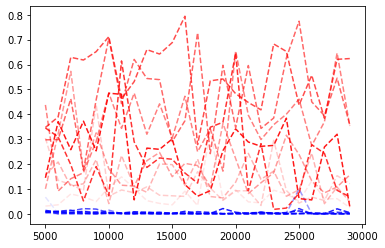

In [1]:
import sys
import numpy as np
import numpy.linalg as la 
from sklearn.preprocessing import normalize
from oct2py import octave
from matplotlib import pyplot as plt 
from scipy import signal
from sklearn.decomposition import fastica
from itertools import permutations, product
from scipy import stats
import random
import math
from tqdm import tqdm


def plusAndMinusPermutations(items):
    for p in permutations(items):
        for signs in product([-1,1], repeat=len(items)):
            yield [a*sign for a,sign in zip(p,signs)]

def Frobenius_Norm(A, A_):
    return np.sqrt(np.trace(np.subtract(A, A_)@np.subtract(A,A_).conj().T))

octave.addpath('~/Github/NSF-Phase1/Blaine/fastica');
def radial_fb(X, val, q): # Set q to be the qth quantile
    return 1 / np.quantile((X.T).dot(val), q)

def compute_polar_fb(X, q, n):
    polar_body = np.ones((n,0))
    for i in range(X.shape[1]):
        if radial_fb(X, X[:,i] / la.norm(X[:,i]), q) >= la.norm(X[:,i]):
            yeet = np.array(X[:,i]).reshape(n, 1)
            polar_body = np.hstack((polar_body, yeet))
    return polar_body

def compute_fb(X, q, n):
    Kpol = compute_polar_fb(X, q, n)
    floating_body = np.ones((n,0))
    maxVal = 0
    maxPoint = np.ones((n,0))
    for i in range(X.shape[1]):
        dotValMat = (X[:,i].T).dot(Kpol)
        for j in range(dotValMat.shape[0]):
            if dotValMat[j] > maxVal:
                maxVal = dotValMat[j]        
        if maxVal <= 1:
            maxPoint = np.array(X[:,i]).reshape(n,1)
            floating_body = np.hstack((floating_body, maxPoint))
        maxVal = 0
    return floating_body
def Get_Min(A,A_):
    i = np.eye(A.shape[0])
    perm = list(plusAndMinusPermutations(i))
    min = Frobenius_Norm(A, A_)
#     print("A:")
#     print(A)
#     print("")
#     print("A_:")
#     print(A_)
#     print("")
    for j in perm:
        j = np.array(j)
        j[j == -0] = 0
        mat = A@np.array(j)
#         print("Guess:")
#         print(mat)
#         print("")
        temp = Frobenius_Norm(mat, A_)
#         print(temp)
        if(temp < min):
#             print("MIN:")
#             print(mat)
#             print("")
            min = temp
        
    return min


samp = np.arange(5000, 30000, 1000)
p_arr = np.arange(.1, 1, .1)
n = 2
#Generate A Random Matrix Given n and samples
#print("Generated a", n, "x", samples, "matrix of Uniform RND samples...") 
plots = False
verbose = False
tqd = True
if(tqd):
    pbar = tqdm(total=100)
for p_ in p_arr:
    Error = np.array([])
    Error1 = np.array([])
    for samples in range(5000, 30000, 1000):
        if(tqd):
            pbar.update(.4)
        sum_0 = 0
        sum_1 = 0
        for i in range(5):
            S = np.zeros((n,1))

            #Uniform samples from the n-dimensional simplex 
            for i in range(int(p_*samples)):
                U = np.random.uniform(0,1,n)
                tmp = np.array([0,1])
                Final = np.zeros(n)
                U = np.hstack((U,tmp))
                U = np.sort(U)
                for i in range(1,n+1):
                    Final[i-1] = U[i] - U[i-1]
                S = np.hstack((S, np.reshape(Final, (n,1))))
            S = np.delete(S, 0,1)

            #Uniform in the l-1 ball by flipping signs
            for i in range(S.shape[1]):
                binom = np.random.binomial(1,.5)
                if(binom == 1):
                    S[0][i] = S[0][i]*(-1)
            for i in range(S.shape[1]):
                binom = np.random.binomial(1,.5)
                if(binom == 1):
                    S[1][i] = S[1][i]*(-1)

            for i in range(int((1-p_)*samples)):
                U = np.random.standard_cauchy((n,1))
                S = np.hstack((S, U))


            #Copying S to perserve the original without noise
            OG_S = np.copy(S)
            if(plots):
                plt.plot(OG_S[0,:], OG_S[1,:], "or", markersize = 0.5)
                plt.title("Original S")
                plt.show()
            if(plots):
                #Plot the now noisy l-1 ball
                plt.plot(S[0,:], S[1,:], "og", markersize = 0.5)
                plt.title("Noisy S")
                plt.show()
                
            p = 1
            A = np.random.normal(0,1,(n,n))
           
            #Computing the repmat
            sqrt = np.sqrt(np.sum(A**2, axis = 0))
            A = A  / (np.tile(sqrt,(n,1)))

            #ICA Definition (Noisy samples)
            X_ = A@S
            #ICA definition with original samples 
            X = A@OG_S
            
            if(plots):
                #Plot Transformed S, and Transformed original samples
                plt.plot(X_[0,:], X_[1, :], "og", markersize = .9)
                plt.title("A@Noisy_S")
                plt.show()
                plt.plot(X[0,:], X[1, :], "ob", markersize = .9)
                plt.title("A@Original_S")
                plt.show()
                
            # w/o Floating Body
            if(verbose):
                print("Computing ICA w/o Floating Body")
            T = np.random.gamma(((X_.shape[0])/p)+1, 1, (1,X_.shape[1]))
            Q = X_ * np.tile(T**(1/p),(X_.shape[0],1))


            M_til = octave.o2pfastica(Q)
            #A_til = la.inv(M_til)
            A_til = np.copy(M_til)
            #A_til = normalize(A_til)?
            B_til = A_til@OG_S
            diff = Get_Min(A_til, A) 
            if(verbose):
                print(f"Error: {diff}")
                print(f"Number of added Cauchy: {int((1-p_)*samples)}")
                print("")
            if (plots):
                plt.plot(B_til[0,:], B_til[1,:], "ob", markersize = 0.3)
                plt.plot(X[0,:], X[1,:], "or", markersize = 0.3)
                plt.title("Blue: Result of ICA(X_) \nRed: Result of ICA(X)")

            sum_0 += diff

            # w/Floating Body
            if(verbose):
                print("Computing ICA w/ Floating Body")
            fb = compute_fb(X, .95, n)
            if(plots):
                plt.plot(X[0,:], X[1,:], "or", markersize = 0.3)
                plt.plot(fb[0,:], fb[1,:], "ob", markersize = 0.3)
            T = np.random.gamma(((fb.shape[0])/p)+1, 1, (1,fb.shape[1]))
            Q = fb * np.tile(T**(1/p),(fb.shape[0],1))

            M_til_fb = octave.o2pfastica(Q)
            #A_til_fb = la.inv(M_til_fb)
            A_til_fb = np.copy(M_til_fb)
            #A_til_fb = normalize(A_til_fb)
            B_til_fb = A_til_fb@OG_S
            
            diff1 = Get_Min(A_til_fb, A)
            if(plots):
                plt.plot(B_til_fb[0,:], B_til_fb[1,:], "ob", markersize = 0.3)
                plt.plot(B_til[0,:], B_til[1,:], "og", markersize = 0.3)
                plt.plot(X[0,:], X[1,:], "or", markersize = 0.3)
                plt.plot([0, A_til_fb[0,0]], [0, A_til_fb[1,0]], "k-")
                plt.plot([0, A_til_fb[0,1]], [0, A_til_fb[1,1]], "k-")
                plt.plot([0, A[0,0]], [0, A[1,0]], "c-")
                plt.plot([0, A[0,1]], [0, A[1,1]], "c-")
                plt.plot([0, A_til[0,0]], [0, A_til[1,0]], "m-")
                plt.plot([0, A_til[0,1]], [0, A_til[1,1]], "m-")
                plt.plot(fb[0,:], fb[1,:], "ob", markersize = 0.3)
                plt.title("Blue: ICA(FB(X_)) \n Green: ICA(X_) \n Red: X")
                plt.show()
            sum_1 += diff1
            if(verbose):
                print(f"FB Error: {diff1}")
                print(f"Number of added Cauchy: {int((1-p_)*samples)}")
                print("")
        if(verbose):
            print(f"Done for {samples} samples!")
            print(f"Average error w/o: {sum_0/2}")
            print(f"Average error w/: {sum_1/2}")
            print("")
        Error = np.append(Error, sum_0/5)
        Error1 = np.append(Error1, sum_1/5)
    plt.plot(samp, Error, "--", color="b", alpha=p_)
    plt.plot(samp, Error1, "--", color="r", alpha=p_)
plt.show()

In [ ]:
plt.show()